# Question 4-5

In [1]:
import json
import datetime
import pytz
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from statistics import mean
import statsmodels.api as sm

/home/fs/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
path = "../../projects/project_5/ECE219_tweet_data/"

files = ["tweets_#gohawks.txt", "tweets_#gopatriots.txt", \
        "tweets_#nfl.txt", "tweets_#patriots.txt", \
        "tweets_#sb49.txt", "tweets_#superbowl.txt"]
topics = ["gohawks", "gopatriots", "nfl", "patriots", "sb49", "superbowl"]

for i, fl in enumerate(files):
    print("files[" + str(i) + "] => " + fl)

files[0] => tweets_#gohawks.txt
files[1] => tweets_#gopatriots.txt
files[2] => tweets_#nfl.txt
files[3] => tweets_#patriots.txt
files[4] => tweets_#sb49.txt
files[5] => tweets_#superbowl.txt


#### Here we need to choose features by ourselves. The features in previous part are kept except for hour of the day. Find new features to use in the twitter object

In [3]:
tmp_path = "./"
tmp_file = 'tmp.txt'
tmp_a = []
for line in open(tmp_path + tmp_file, 'r'):
    tmp_a.append(json.loads(line))
    
a_show = tmp_a[1]

print(json.dumps(a_show, indent=4, sort_keys=True))

{
    "author": {
        "author_img": "http://pbs.twimg.com/profile_images/3500051520/6df4b26b0f9af8bb521415c665f9f257_normal.jpeg",
        "description": "Native Spanish tutor / teacher with 12 years experience with students of all ages in downtown Bellevue, WA.",
        "followers": 51.0,
        "image_url": "http://pbs.twimg.com/profile_images/3500051520/6df4b26b0f9af8bb521415c665f9f257_normal.jpeg",
        "name": "Jennifer P.",
        "nick": "bellevuespanish",
        "type": "twitter",
        "url": "http://twitter.com/bellevuespanish"
    },
    "citation_date": 1421538677,
    "citation_url": "http://twitter.com/BellevueSpanish/status/556599673738100736",
    "firstpost_date": 1421538677,
    "highlight": "Free Lyft ride up to $10 for first-timers using link http://t.co/OppoRltpDg  #Gohawks http://t.co/JW42hvna3F",
    "metrics": {
        "acceleration": 0,
        "citations": {
            "data": [
                {
                    "citations": 0,
             

number of mentioned user in this tweet

In [4]:
len(a_show['tweet']['entities']['user_mentions'])

0

number of media url attached

In [5]:
len(a_show['tweet']['extended_entities']['media']) if 'extended_entities' in a_show['tweet'] else 0

1

activite index defined by year

In [6]:
# total number of tweets posted by the user since account created
hist_tweet = a_show['tweet']['user']["statuses_count"]

# year the account was created
hist_year = a_show['tweet']['user']['created_at'][-4:]

# active index defined by year
hist_tweet/(2015-float(hist_year)+1)

314.3333333333333

author name

In [7]:
a_show['author']['name']

'Jennifer P.'

user's favourites count

In [8]:
a_show['tweet']['user']['favourites_count']

11

length of this tweet's title

In [9]:
len(a_show['title'])

108

#### Prepare for data

In [10]:
def prase_dataset(file):
    """
    Prase x conponent of the dataset into pandas DataFrame including columns of:
    tweets, retweets, total_followers, max_followers, mentioned, media, active, author, favourites_count, title
    with lines of hours,
    where mentioned: number of @ in tweets per hour
          media: number of url in tweets per hour
          active: a measure of active state of author
          author: number of unique authors post tweet per hour
          favourites_count: the total number of likes by this user
          title: length of this tweet's title
    Prase y of dataset as number of tweets in the next hour.
    """
   
    # extract raw features
    pst_tz = pytz.timezone('America/Los_Angeles')
    data_raw = []
    for line in open(path + file, 'r') :
        row_tmp = []
        a = json.loads(line)
        time = a['citation_date']
        retweet = a['metrics']['citations']['total']
        foll = a['author']['followers']             
        ment = len(a['tweet']['entities']['user_mentions'])        
        medi = len(a['tweet']['extended_entities']['media']) if 'extended_entities' in a['tweet'] else 0
        hist_tw = a['tweet']['user']["statuses_count"]
        hist_yr = a['tweet']['user']['created_at'][-4:]
        acti = hist_tw/(2015-float(hist_yr)+1) 
        auth = a['author']['name']
        favo = a['tweet']['user']['favourites_count']
        titl = len(a['title'])
        
        # append to list
        row_tmp.append(time)
        row_tmp.append(retweet)
        row_tmp.append(foll)    
        row_tmp.append(ment) 
        row_tmp.append(medi) 
        row_tmp.append(acti)  
        row_tmp.append(auth)
        row_tmp.append(favo)
        row_tmp.append(titl)        
        data_raw.append(row_tmp)
    
    # sort according to time
    pddata_raw = pd.DataFrame(data_raw,columns=['time','retweets','followers','mentioned','media',\
                                                'active','author','favourites_count','title'])
    pddata_raw = pddata_raw.sort_values(by = 'time')
    pddata_raw = pddata_raw.reset_index(drop=True)
    pddata_raw['tweets'] = 1                   
#     print(pddata_raw)

    # reset time to hour index
    hour_accu = []
    hour_day = []
    for index, row in pddata_raw.iterrows():  
        p = datetime.datetime.fromtimestamp(row["time"], pst_tz)  
        hour_accu.append(((p.month-1)*31+p.day-14)*24+p.hour)
        hour_day.append(p.hour)    
    pddata_raw["time"] = hour_accu
    pddata_raw["hour of day"] = hour_day
    
    # create a new dataframe with desired form
    df = pd.DataFrame([],columns=['hour index','tweets','retweets','followers sum','followers max',\
                                  'mentioned','media','active','author','favourites_count','title'])
    df['hour index'] = range(pddata_raw.iloc[len(pddata_raw.index)-1,0]+1)
    df['tweets'] = pddata_raw.groupby("time")['tweets'].sum()
    df['retweets'] = pddata_raw.groupby("time")['retweets'].sum()
    df['followers sum'] = pddata_raw.groupby("time")['followers'].sum()
    df['followers max'] = pddata_raw.groupby("time")["followers"].max()
    df['mentioned'] = pddata_raw.groupby("time")['mentioned'].sum()
    df['media'] = pddata_raw.groupby("time")['media'].sum()
    df['active'] = pddata_raw.groupby("time")['active'].mean()  
    df['author'] = pddata_raw.groupby("time")['author'].nunique() # count number of not-repeating authors    
    df['favourites_count'] = pddata_raw.groupby("time")['favourites_count'].sum()
    df['title'] = pddata_raw.groupby("time")['title'].mean()
            
    # reset index of df
    df = df.drop([0]).fillna(0).reset_index(drop=True)

    # assign number of tweets of the next hour to be the target value
    df_y = df.iloc[1:,1].reset_index(drop=True)
    df = df[:len(df_y)]
    
    return df.iloc[:,1:],df_y

#### Train linear regression model

In [11]:
def train_lr(i):
    """
    This function gets data and train using a linear regression model
    """    
    df, df_y = prase_dataset(files[i])

    reg = LinearRegression().fit(df, df_y)
    pred_y = reg.predict(df)
    MSE = mean_squared_error(df_y, pred_y)
    R2 = r2_score(df_y, pred_y)
    
    print(topics[i])
    print('MSE for test data = ',MSE)
    print('R2 score for test data = ',R2)   
    
    return df, df_y, pred_y

In [12]:
def plot_recipe(df_y, pred_y):
    """
    This function plots fitted values vs true values
    """
    plt.figure()
    area = np.pi * (4)**2/4
    plt.scatter(df_y, pred_y, s = area)
    plt.plot([df_y.min(), df_y.max()], [df_y.min(), df_y.max()], 'k--', lw = 1)
    plt.xlabel('true values')
    plt.ylabel('fitted values')
    plt.show()

In [13]:
features = ['tweets', 'retweets', 'followers sum', 'followers max', \
            'mentioned', 'media', 'active', 'author', 'favourites_count', 'title']

def plot_feature_vs_pred(df,pred_y,features,top3):
    for i in top3:
        plt.figure()
        area = np.pi * (4)**2/4
        plt.scatter(df[features[i]], pred_y, s = area)
        plt.xlabel('feature: '+features[i])
        plt.ylabel('fitted values')
    plt.show()        

In [14]:
def ols_regression(df, df_y):
    X2 = sm.add_constant(df)
    y = df_y.as_matrix()
    lm = sm.OLS(y, X2).fit()
    print(lm.summary())
    print(list(df))

## Results

#### gohawks

gohawks
MSE for test data =  507327.11979189696
R2 score for test data =  0.6504331824666223


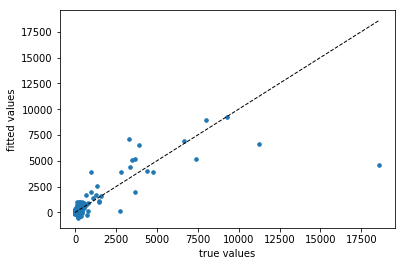

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     105.3
Date:                Wed, 20 Mar 2019   Prob (F-statistic):          3.29e-122
Time:                        00:37:40   Log-Likelihood:                -4608.7
No. Observations:                 577   AIC:                             9239.
Df Residuals:                     566   BIC:                             9287.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              100.2750    185.620  

In [15]:
df, df_y, pred_y = train_lr(0)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

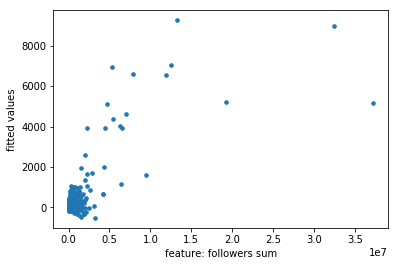

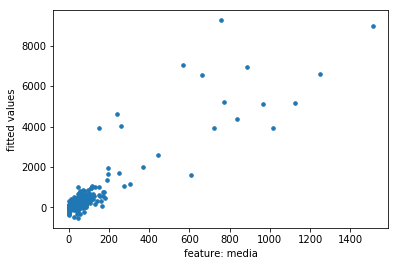

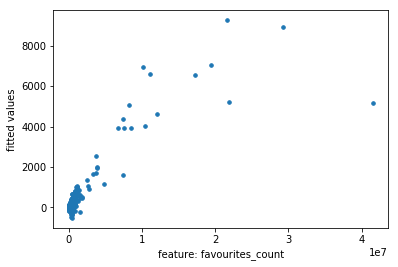

In [16]:
plot_feature_vs_pred(df,pred_y,features,[2,5,8])

#### gopatriots

gopatriots
MSE for test data =  7491.2958942428295
R2 score for test data =  0.8993519972877009


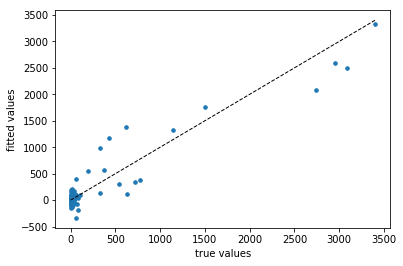

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     503.1
Date:                Wed, 20 Mar 2019   Prob (F-statistic):          3.46e-273
Time:                        00:38:54   Log-Likelihood:                -3374.9
No. Observations:                 574   AIC:                             6772.
Df Residuals:                     563   BIC:                             6820.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.0352      7.058  

In [17]:
df, df_y, pred_y = train_lr(1)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

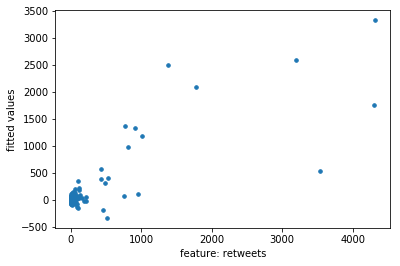

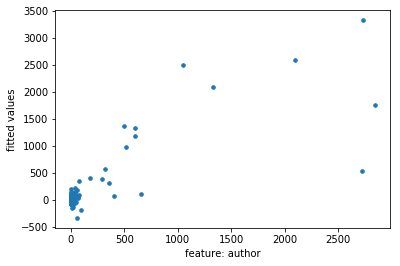

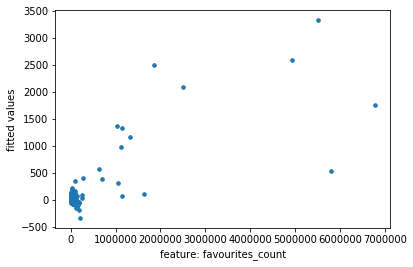

In [18]:
plot_feature_vs_pred(df,pred_y,features,[1,7,8])

#### nfl

nfl
MSE for test data =  176690.48676121133
R2 score for test data =  0.7195246919677531


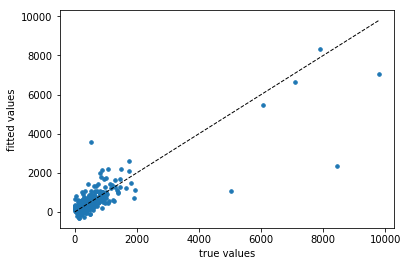

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     147.3
Date:                Wed, 20 Mar 2019   Prob (F-statistic):          2.77e-151
Time:                        00:44:00   Log-Likelihood:                -4364.1
No. Observations:                 585   AIC:                             8750.
Df Residuals:                     574   BIC:                             8798.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              203.4057    189.215  

In [19]:
df, df_y, pred_y = train_lr(2)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

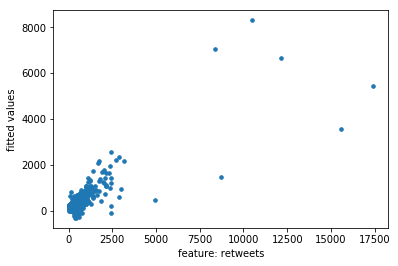

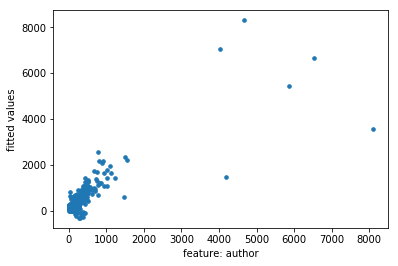

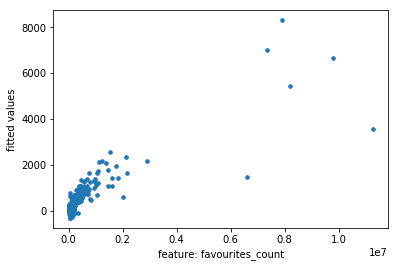

In [20]:
plot_feature_vs_pred(df,pred_y,features,[1,7,8])

#### patriots

patriots
MSE for test data =  3702663.51290001
R2 score for test data =  0.7634208931447117


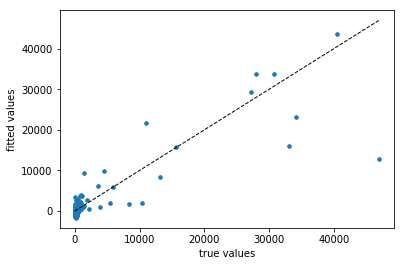

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     185.2
Date:                Wed, 20 Mar 2019   Prob (F-statistic):          2.14e-172
Time:                        00:45:26   Log-Likelihood:                -5254.0
No. Observations:                 585   AIC:                         1.053e+04
Df Residuals:                     574   BIC:                         1.058e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             5191.9213   1411.553  

In [21]:
df, df_y, pred_y = train_lr(3)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

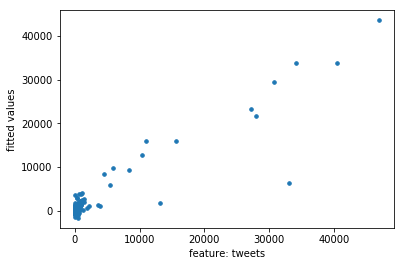

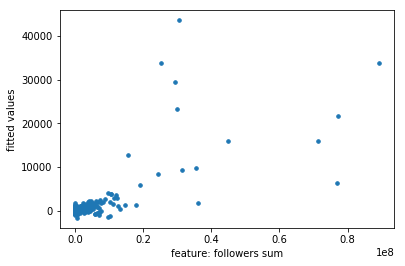

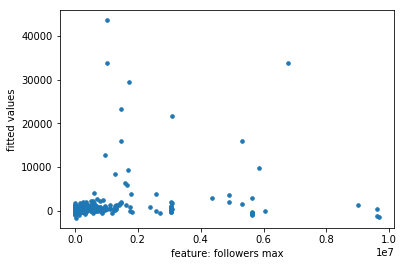

In [22]:
plot_feature_vs_pred(df,pred_y,features,[0,2,3])

#### sb49

sb49
MSE for test data =  13092915.122208426
R2 score for test data =  0.8411572479002133


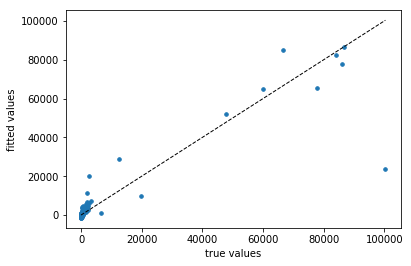

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     304.0
Date:                Wed, 20 Mar 2019   Prob (F-statistic):          6.99e-222
Time:                        00:47:37   Log-Likelihood:                -5623.4
No. Observations:                 585   AIC:                         1.127e+04
Df Residuals:                     574   BIC:                         1.132e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              136.5785    485.248  

In [23]:
df, df_y, pred_y = train_lr(4)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

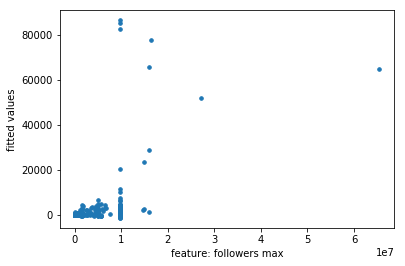

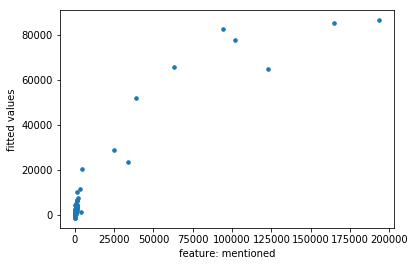

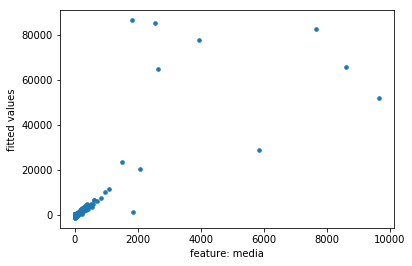

In [24]:
plot_feature_vs_pred(df,pred_y,features,[3,4,5])

#### superbowl

superbowl
MSE for test data =  25529353.588371396
R2 score for test data =  0.9028004478858149


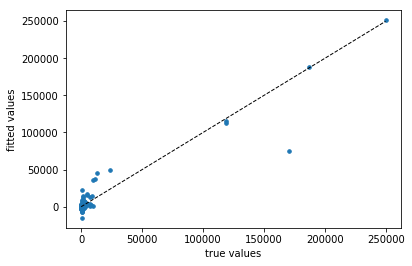

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     533.1
Date:                Wed, 20 Mar 2019   Prob (F-statistic):          5.61e-283
Time:                        00:50:05   Log-Likelihood:                -5818.8
No. Observations:                 585   AIC:                         1.166e+04
Df Residuals:                     574   BIC:                         1.171e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             3399.0244   3280.489  

In [25]:
df, df_y, pred_y = train_lr(5)
plot_recipe(df_y,pred_y)
ols_regression(df, df_y)

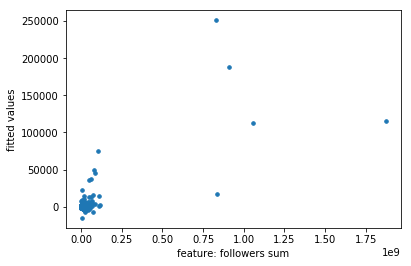

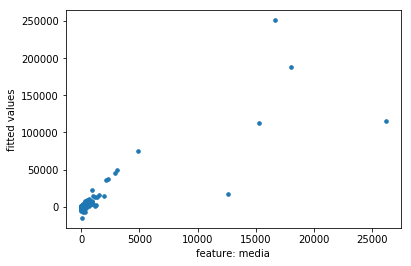

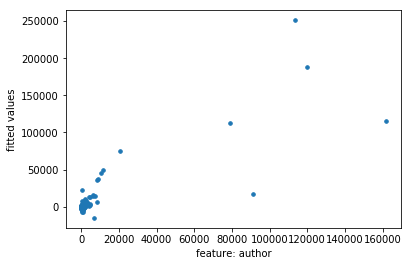

In [26]:
plot_feature_vs_pred(df,pred_y,features,[2,5,7])